# Imports et Constantes

Je préfère mettre les imports et constantes tout en haut au fur et a mesure que j'en ai besoin.

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [ ]:
HALFDATASETSIZE = 300
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MOMENTUM = 0.9

# Récupération des données

Connexion au drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Comment accéder aux données ?

In [ ]:
folder_path = '/content/drive/My Drive/chest_xray/train/PNEUMONIA'

image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')] #noms des images
print("nombre d'images dans le dossier :", len(image_files))

sizes = []
k = 0
for file_name in image_files:
    k += 1
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)

    sizes.append(image.shape)

    if k == 10 :
      break

print(sizes)


nombre d'images dans le dossier : 3882
[(469, 796, 3), (512, 896, 3), (1006, 1404, 3), (704, 1168, 3), (744, 920, 3), (936, 1292, 3), (752, 1016, 3), (600, 1008, 3), (1164, 1600, 3), (672, 1216, 3)]


On voit d'abord que les images sont encodées en couleur (3 channels)\
On voit aussi que toutes les images ont des tailles différentes : il faudra régler ça\
On va les mettre en 128x128

Exemple sur une image :

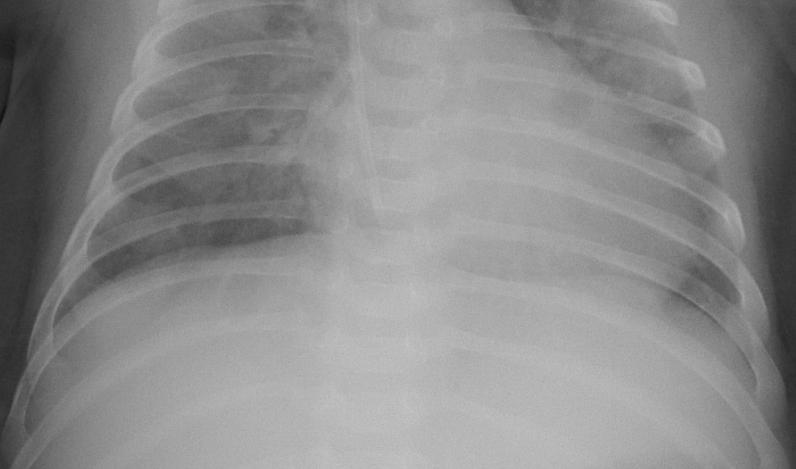

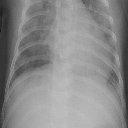

In [ ]:
filename = image_files[0]
file_path = os.path.join(folder_path, filename)
image = cv2.imread(file_path)
cv2_imshow(image)
resized_image = cv2.resize(image, (128, 128))
cv2_imshow(resized_image)

La première image est originale, la seconde en 128x128

In [ ]:
r = np.array(image[:,:,0])
g = np.array(image[:,:,1])
b = np.array(image[:,:,2])

print(r[:10,:10])
print(g[:10,:10])
print(b[:10,:10])

[[49 49 49 50 50 50 51 51 51 53]
 [49 50 50 50 51 51 51 52 52 52]
 [50 51 51 51 52 52 52 53 52 52]
 [51 51 52 52 52 53 53 53 53 52]
 [51 51 52 52 52 53 53 53 53 52]
 [50 51 51 51 52 52 52 53 52 52]
 [49 50 50 50 51 51 51 52 52 52]
 [49 49 49 50 50 50 51 51 51 53]
 [52 51 49 49 51 51 49 48 53 52]
 [52 51 49 49 51 51 49 48 53 52]]
[[49 49 49 50 50 50 51 51 51 53]
 [49 50 50 50 51 51 51 52 52 52]
 [50 51 51 51 52 52 52 53 52 52]
 [51 51 52 52 52 53 53 53 53 52]
 [51 51 52 52 52 53 53 53 53 52]
 [50 51 51 51 52 52 52 53 52 52]
 [49 50 50 50 51 51 51 52 52 52]
 [49 49 49 50 50 50 51 51 51 53]
 [52 51 49 49 51 51 49 48 53 52]
 [52 51 49 49 51 51 49 48 53 52]]
[[49 49 49 50 50 50 51 51 51 53]
 [49 50 50 50 51 51 51 52 52 52]
 [50 51 51 51 52 52 52 53 52 52]
 [51 51 52 52 52 53 53 53 53 52]
 [51 51 52 52 52 53 53 53 53 52]
 [50 51 51 51 52 52 52 53 52 52]
 [49 50 50 50 51 51 51 52 52 52]
 [49 49 49 50 50 50 51 51 51 53]
 [52 51 49 49 51 51 49 48 53 52]
 [52 51 49 49 51 51 49 48 53 52]]


En fait, les images sont en noir et blanc : inutile de travailler avec les 3 channels\
\
On ne va travailler qu'avec train et test (on oublie val)

# Equilibrage du dataset

TRES IMPORTANT : il faut regarder si le dataset est équilibré (nombre d'images de chaque type égaux). On peut le faire facilement avec l'explorateur de fichiers.
Directement dans le notebook :

In [ ]:
folder_path_train_P = '/content/drive/My Drive/chest_xray/train/PNEUMONIA'
folder_path_train_N = '/content/drive/My Drive/chest_xray/train/NORMAL'
folder_path_test_P = '/content/drive/My Drive/chest_xray/test/PNEUMONIA'
folder_path_test_N = '/content/drive/My Drive/chest_xray/test/NORMAL'

image_files_train_P = [f for f in os.listdir(folder_path_train_P) if f.endswith('.jpeg')]
image_files_train_N = [f for f in os.listdir(folder_path_train_N) if f.endswith('.jpeg')]
image_files_test_P = [f for f in os.listdir(folder_path_test_P) if f.endswith('.jpeg')]
image_files_test_N = [f for f in os.listdir(folder_path_test_N) if f.endswith('.jpeg')]

print("nombre d'images train P :", len(image_files_train_P))
print("nombre d'images train N :", len(image_files_train_N))
print("nombre d'images test P :", len(image_files_test_P))
print("nombre d'images test N :", len(image_files_test_N))

nombre d'images train P : 3882
nombre d'images train N : 1341
nombre d'images test P : 390
nombre d'images test N : 234


C'est un peu déséquilibré, soit on s'en fiche (pas trop déséquilibré), soit on enleve des images de train P pour passer a 1341 (on perds un peu de data mais pas tres grave), soit on fait des trucs plus compliqué.\
Pour des problèmes de place on va garder 300 de chaque pour l'instant, valeur qu'on va stocker dans HALFDATASETSIZE

In [ ]:
image_files_train_P = image_files_train_P[:HALFDATASETSIZE]
image_files_train_N = image_files_train_N[:HALFDATASETSIZE]

# Equilibrage de test

Ne pas s'occuper de cette partie avant la fin du notebook

In [ ]:
if False :
  image_files_test_P = image_files_test_P[:234]

  print("nombre d'images test P :", len(image_files_test_P))
  print("nombre d'images test N :", len(image_files_test_N))

# Pytorch Dataset

On va utiliser pytorch. on va d'abord passer les données en numpy puis sous le format accepté par pytorch\
On va en profiter pour les mettre sous la forme (1,128,128)\
(nb : si on voulait un notebook vraiment propre, on stockerai 128 dans une variable globale, mais ici le projet est pas énorme donc pas besoin)

In [ ]:
def load_images(folder_path, filenames):
    images = []
    for filename in filenames:
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = img[:,:,0] #On garde 1 channel
            img = cv2.resize(img, (128, 128)) #format = (128,128)
            img = np.expand_dims(img, axis=0) #format = (1,128,128)
            images.append(img)
    return images

In [ ]:
images_train_P = load_images(folder_path_train_P, image_files_train_P)
print('a')
images_train_N = load_images(folder_path_train_N, image_files_train_N)
print('b')
images_test_P = load_images(folder_path_test_P, image_files_test_P)
print('c')
images_test_N = load_images(folder_path_test_N, image_files_test_N)

a


On va maintenant mélanger les PNEUMONIA et les NORMAL, et créer les labels, 0 pour NORMAL, 1 pour PNEUMONIA

In [ ]:
train_images = images_train_P + images_train_N
test_images = images_test_P + images_test_N

train_labels = [1 for i in range(len(images_train_P))] + [0 for i in range(len(images_train_N))]
test_labels = [1 for i in range(len(images_test_P))] + [0 for i in range(len(images_test_N))]

Les listes ne sont pas encore mélangées. Attention a garder la correspondance entre data et labels pendant le mélange

In [ ]:
train_data = list(zip(train_images, train_labels))
test_data = list(zip(test_images, test_labels))

random.shuffle(train_data)
random.shuffle(test_data)

train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Attention à bien normaliser, sinon ça marche pas (pytorch veut des valeurs entre 0 et 1).\
Check ça doit être votre premier réflexe si vous travaillez sur des images, que le code ne crash pas mais que vous avez des résultats comparable a un algo aléatoire.

In [ ]:
train_images = train_images/255
test_images = test_images/255

passage en pytorch tensor :

In [ ]:
train_images_tensor = torch.tensor(train_images, dtype=torch.float)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_images_tensor = torch.tensor(test_images, dtype=torch.float)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

#Model

Définition du modèle

Dans init, on définit les couches qu'on utilise dans le réseau (l'ordre n'a pas d'importance, et on peut utiliser une couche ainsi définie plusieurs fois de suite.\
Dans forward, on va construire le réseau en plaçant les couches les unes à la suite des autres.\
C'est plus simple de compléter init et forward en mème temps : on complète forward et dès qu'on a besoin d'une couche qui n'existe pas encore, on la définit dans init.\
\
Il est important de bien suivre le format des images, qui va être modifié dans le forward : personnellement je le note en commentaire dans le forward après chaque couche.\
\
Le format qu'on veut pour l'instant : deux couches de convolution (avec du pooling), puis un flatten puis deux couches denses. On utilisera des relu comme activation et On veut à la fin une valeur entre 0 et 1.\
\
Les fonctions à utiliser (cherchez leur doc sur internet):
- `nn.Conv2d`
- `nn.MaxPool2d`
- `nn.Linear`
- `F.relu`
- `torch.flatten`

Attention avec le torch.flatten : le réseau ne va pas prendre les images une par une, mais par batch, le format d'un batch est (BATCH_SIZE, x, x) pour un batch d'images de taille (x,x). et on ne veut pas flatten toutes les images du batch mais plutôt avoir un batch d'images flatten.

In [ ]:
class Net(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.nom_de_la_couche_à_remplacer = nn.

  def forward(self, x) : # dimension de x : (128,128), en général je met les dimensions en sortie de couche après la couche.
    x = self.
    return x.squeeze() # le squeeze enlève tous les 1 des dimensions

Il faut maintenant créer le réseau basé sur ce modèle

In [ ]:
my_nn = Net()
print(my_nn)

On a un résumé du init

On va maintenant définir une loss (criterion), pour de la classification binaire. A vous de chercher.

In [ ]:
criterion =

Optimizer :

In [ ]:
optimizer = optim.SGD(my_nn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Training

Ici on entraine le modèle.\
Il se passe différente choses. Pour tout ce qui utilise dataloader, c'est compliqué, en gros ca permet d'itérer sur les données.\
La variable "running_loss" est superficielle, elle sert juste pour l'affichage et ne joue pas de rôle concret dans l'entrainement.

plusieurs commentaires à compléter.\
\
Pour outputs =, on veut tout simplement l'output de notre modèle pour les inputs "inputs".\
\
Pour loss =, on veut calculer la loss relative aux outputs et aux labels, on utilisera la fonction criterion définie plus haut.\
\
Pour la mise à jour de running_loss, on veut l'incrémenter de la loss supplémentaire due au nouveau tour de boucle. attention l'objet "loss" n'est pas un float mais un objet torch compliqué, on récupère le float qui nous intéresse via loss.item()\
\
Pour les autres trous, les lignes à utiliser sont :
- `optimizer.step()`
- `optimizer.zero_grad()`
- `loss.backward()`

A vous de trouver laquelle mettre où

In [ ]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    dataloader = tqdm(range(0, len(train_images_tensor), BATCH_SIZE), position=0, leave=True)

    for i in dataloader:
        inputs = train_images_tensor[i:i+BATCH_SIZE]
        labels = train_labels_tensor[i:i+BATCH_SIZE]

        #Ici on réinitialise les gradients

        outputs = #A compléter
        loss = #A compléter

        #Ici on calcule la loss (et les gradients en passant)

        #Ici on mets à jour les poids selon les gradients calculés

        #Ici on met à jour running_loss pour l'affichage

        dataloader.set_description(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_images_tensor):.5f}')
        dataloader.refresh()

dataloader.close()

print('Training finished')

# Evaluation

Ici, le but est d'évaluer notre réseau sur des données n'ayant pas servi à l'entrainement. On va utiliser la partie test du dataset.\
\
Demander à notre réseau une prédiction pour chacune des images du dataset test, et on va regarder son pourcentage de réussite.\
\
Pour cela, complétez l'intérieur de la boucle :
- `inputs doit contenir l'image i du dataset de test`
- `labels doit contenir le label i du dataset de test`
- `on veut ensuite les convertir en torch tensor (regardez plus haut ce qui a été fait pour le train)`
- `outputs est un float entre 0 et 1, or on veut que le réseau décide : on va dire qu'il prédit 0 si output < 0.5 et 1 sinon. On stockera sa réponse dans la variable predicted`
- `On update ensuite total et correct`

In [ ]:
my_nn.eval()  # Mise en mode évaluation (pour éviter des calculs inutiles pendant l'évaluation)
correct = 0
total = 0

with torch.no_grad():  # On désactive le calcul des gradients pendant l'évaluation (inutile)
    for i in range(len(test_images)):
        inputs =
        labels =

        inputs =
        labels =

        outputs = my_nn(inputs.unsqueeze(0))  # Add a batch dimension
        predicted =

        total +=
        correct +=

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')

Attention : Le dataset de test n'était pas équilibré\
\
C'est dangeureux : si votre réseau est mauvais et réponds tout le temps 1, mais que votre dataset de test est majoritairement composé de 1, vous aurez l'impressioin que le réseau fonctionne car l'accuracy sera de 80% par exemple\
\
Pour régler cela, éxecutez la partie "Equilibrage de test", puis réexécutez tout ce qui est nécessaire jusqu'au test.

# Comment améliorer ?

Vous avez maintenant une version fonctionnelle : il reste la partie la plus amusante : modifier les paramètres pour voir l'accuracy grimper !\
\
Pour cela, voici quelques pistes :
- `modifiez la structure du modèle (nombre de couches, de neurones, padding, activations...`
- `optimizer : changer d'optimizer, changer le learning rate...`
- `accélerer les calculs avec cuda (on n'a pour l'instant pas utilisé le potentiel de Colab)`
- `Data augmentation : plus le modèle est grop, plus il lui faut des données`